In this notebook, we perform 3D reconstruction by stereo matching using OpenCV

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [20]:
# Read images
img1 = cv.imread('../../images/stereo/fan0.jpg',0)
img2 = cv.imread('../../images/stereo/fan1.jpg',0)

img1_c = cv.imread('../../images/stereo/fan0.jpg')
img2_c = cv.imread('../../images/stereo/fan1.jpg')

img1_c = cv.cvtColor(img1_c,cv.COLOR_BGR2RGB)
img2_c = cv.cvtColor(img2_c,cv.COLOR_BGR2RGB)

r,c = img1.shape[:2]

In [3]:
# Feature detection by SIFT
sift = cv.SIFT_create()

kp1,des1 = sift.detectAndCompute(img1,None)
kp2,des2 = sift.detectAndCompute(img2,None)

In [4]:
# Feature matching by FLANN based matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

In [5]:
# Ratio test
pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [6]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [7]:
print("Fundamental matrix:")
print(F)

Fundamental matrix:
[[-4.03413825e-07 -1.97967883e-06  5.46102880e-03]
 [ 1.82494158e-06  4.31218247e-07  1.92205439e-03]
 [-4.71870888e-03 -3.02620724e-03  1.00000000e+00]]


In [8]:
import sfm
import camera

In [9]:
# Make inlier points homogeneous

pts1 = np.vstack((pts1.T,np.ones(pts1.shape[0])))
pts2 = np.vstack((pts2.T,np.ones(pts2.shape[0])))

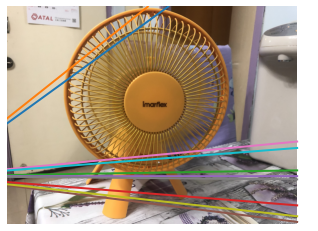

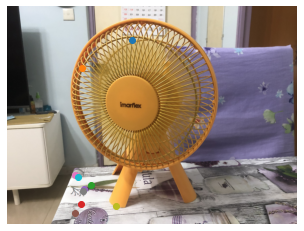

In [29]:
# Plot epipolar lines

e = sfm.compute_epipole(F)

plt.figure()
plt.imshow(img1_c)
for i in range(10):
    sfm.plot_epipolar_line(img1,F,pts2[:,i],e,False)
plt.axis('off')

plt.figure()
plt.imshow(img2_c)
for i in range(10):
    plt.plot(pts2[0,i],pts2[1,i],'o')
plt.axis('off')

plt.show()

In [22]:
# First camera

cam1 = camera.Camera(np.hstack((np.diag([1,1,1]),np.zeros((3,1)))))

K = camera.my_calibration((4032,3024))

In [23]:
# Compute P by assuming a form [S_eF|e]

P_fund = sfm.compute_P_from_fundamental(F)
cam_fund = camera.Camera(P_fund)

points_3d_fund = sfm.triangulate(pts1,pts2,cam1.P,cam_fund.P)

In [24]:
from mpl_toolkits.mplot3d import axes3d

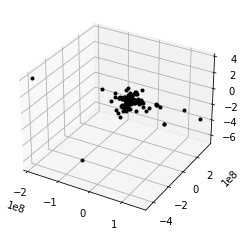

In [25]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(-points_3d_fund[0],points_3d_fund[1],points_3d_fund[2],'k.')

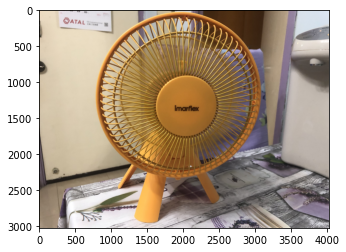

In [27]:
# Reproject to original image 1

project_1_fund = cam1.project(points_3d_fund)
in_img = (project_1_fund[0,:]>0) & (project_1_fund[1,:]>0) & (project_1_fund[0,:]<c) & (project_1_fund[1,:]<r)

plt.figure()
plt.imshow(img1_c)
plt.plot(project_1_fund[0,in_img],project_1_fund[1,in_img],'o')

plt.show()